In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import windows
from scipy.fft import fftshift

In [117]:
# Read the CSV file
df = pd.read_csv('radar/radar_rotate.csv')
df.head()

,node,data,timestamp
0,radar,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2025-04-24 18:01:50.709287
1,radar,"[402, 283, 312, 384, -169, -119, -87, -23, 389...",2025-04-24 18:01:50.751306
2,radar,"[366, 302, 342, 359, -166, -104, -31, -24, 365...",2025-04-24 18:01:50.797009
3,radar,"[386, 284, 317, 371, -128, -58, -88, 4, 349, 2...",2025-04-24 18:01:50.843099
4,radar,"[363, 267, 293, 351, -101, -54, -49, -37, 299,...",2025-04-24 18:01:50.873531


In [118]:
# read the data column from first row and convert array string to numpy array
data0 = np.array(eval(df.iloc[0, 1]))
data1 = np.array(eval(df.iloc[1, 1]))
data2 = np.array(eval(df.iloc[2, 1]))
dataf0 = np.array(eval(df.iloc[-1, 1]))
dataf1 = np.array(eval(df.iloc[-2, 1]))
dataf2 = np.array(eval(df.iloc[-3, 1]))
print("Data shape:", data0.shape)
print("data0", data0)
print("data1", data1)
print("data2", data2)
print("dataf0", dataf0)
print("dataf1", dataf1)
print("dataf2", dataf2)

Data shape: (2048,)
data0 [   0    0    0 ... -124  -52 -372]
data1 [ 402  283  312 ...    6   50 -421]
data2 [ 366  302  342 ...  -14  115 -399]
dataf0 [ -23  -41   19 ...  -69   45 -157]
dataf1 [  -6  -43   48 ...   59   82 -140]
dataf2 [ -16  -24   51 ...   17   45 -128]


/var/folders/xg/bxlxvkzj4m578fz9rzkh0z0c0000gp/T/ipykernel_14692/1229057847.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


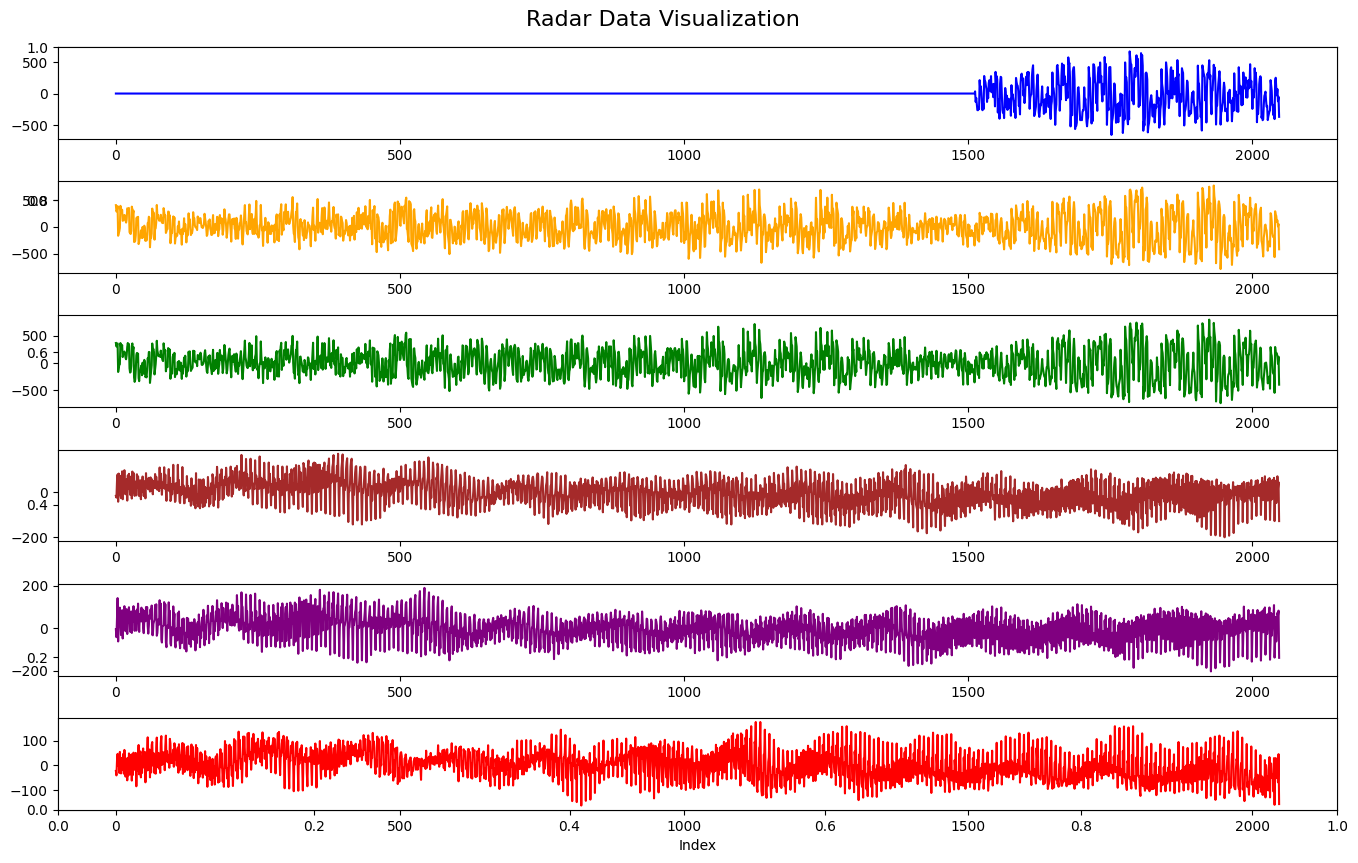

In [119]:
# plot data0, data1, data2, and dataf on subpolots vertically
plt.figure(figsize=(14, 9))
plt.suptitle('Radar Data Visualization', fontsize=16)
plt.legend(loc='upper right')
plt.xlabel('Index')

plt.subplot(6, 1, 1)
plt.plot(data0, label='Data 0', color='blue')

plt.subplot(6, 1, 2)
plt.plot(data1, label='Data 1', color='orange')

plt.subplot(6, 1, 3)
plt.plot(data2, label='Data 2', color='green')

plt.subplot(6, 1, 4)
plt.plot(dataf2, label='Data Final 2', color='brown')

plt.subplot(6, 1, 5)
plt.plot(dataf1, label='Data Final 1', color='purple')

plt.subplot(6, 1, 6)
plt.plot(dataf0, label='Data Final 0', color='red')

plt.tight_layout()


/var/folders/xg/bxlxvkzj4m578fz9rzkh0z0c0000gp/T/ipykernel_14692/1069867318.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


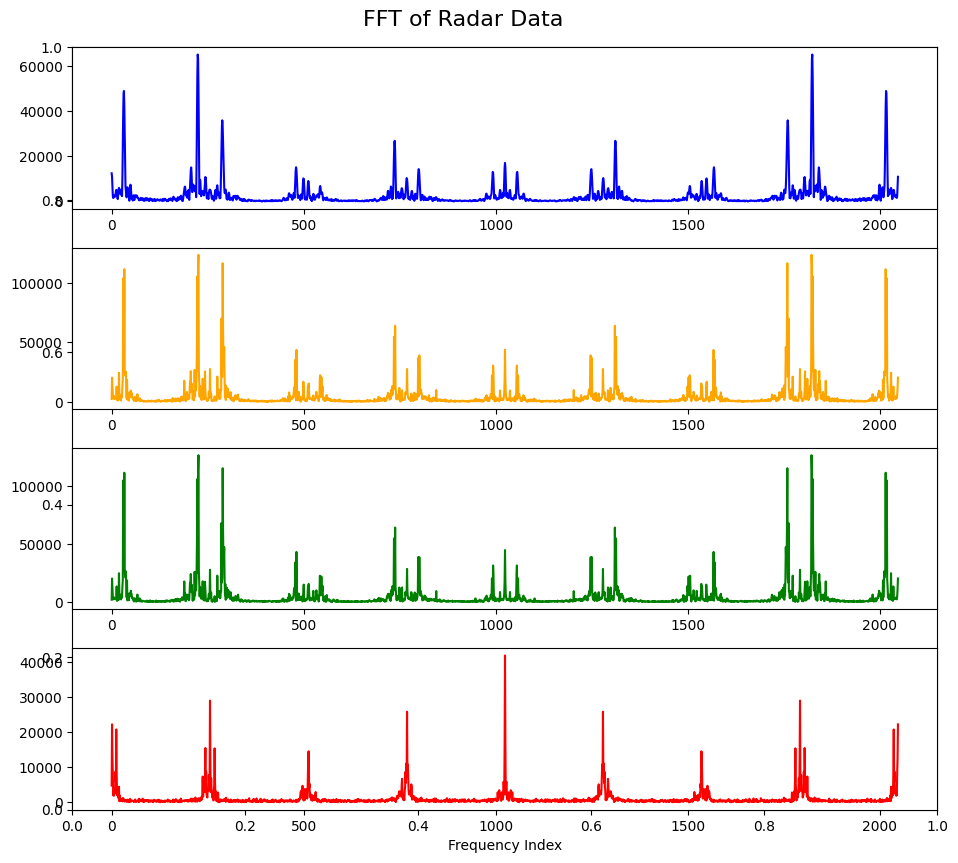

In [120]:
# Do FFT on data0, data1, data2, and dataf
fft_data0 = fft(data0)
fft_data1 = fft(data1)
fft_data2 = fft(data2)
fft_dataf = fft(dataf0)

# Plot the FFT results
plt.figure(figsize=(10, 9))
plt.suptitle('FFT of Radar Data', fontsize=16)
plt.legend(loc='upper right')
plt.xlabel('Frequency Index')

plt.subplot(4, 1, 1)
plt.plot(np.abs(fft_data0), label='FFT Data 0', color='blue')
plt.subplot(4, 1, 2)
plt.plot(np.abs(fft_data1), label='FFT Data 1', color='orange')
plt.subplot(4, 1, 3)
plt.plot(np.abs(fft_data2), label='FFT Data 2', color='green')
plt.subplot(4, 1, 4)
plt.plot(np.abs(fft_dataf), label='FFT Data Final', color='red')

plt.tight_layout()

In [132]:
len(eval(df['data'][0]))

2048

In [133]:
ADC_SAMPLING_RATE = 10000  # Hz, TODO

# FFT on all data streams in pandas
ffts = df.iloc[:, 1].apply(lambda x: fft(np.array(eval(x)))).values
ffts = np.vstack([np.abs(f) for f in ffts]).T  # Shape: (fft_len, num_samples)

# freq vals
freqs = fftfreq(len(data0), 1/ADC_SAMPLING_RATE)

# timestamps in sec
timestamps = pd.to_datetime(df.iloc[:, 2])
tds = (timestamps - timestamps.iloc[0]).dt.total_seconds().values

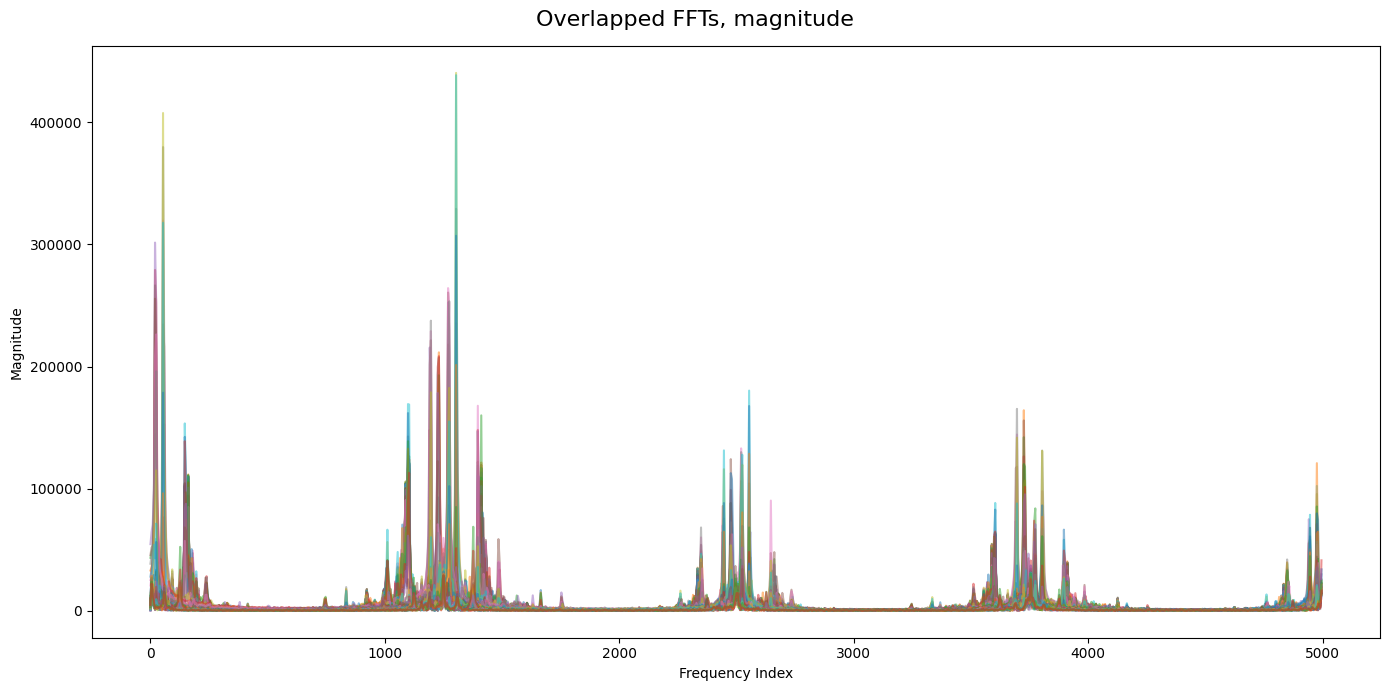

In [134]:
plt.figure(figsize=(14, 7))
plt.suptitle('Overlapped FFTs, magnitude', fontsize=16)
plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
for i in range(ffts.shape[1]):
    plt.plot(freqs[:len(freqs)//2], np.abs(ffts[:len(freqs)//2, i]), label=f'Sample {i+1}', alpha=0.5)
plt.tight_layout()

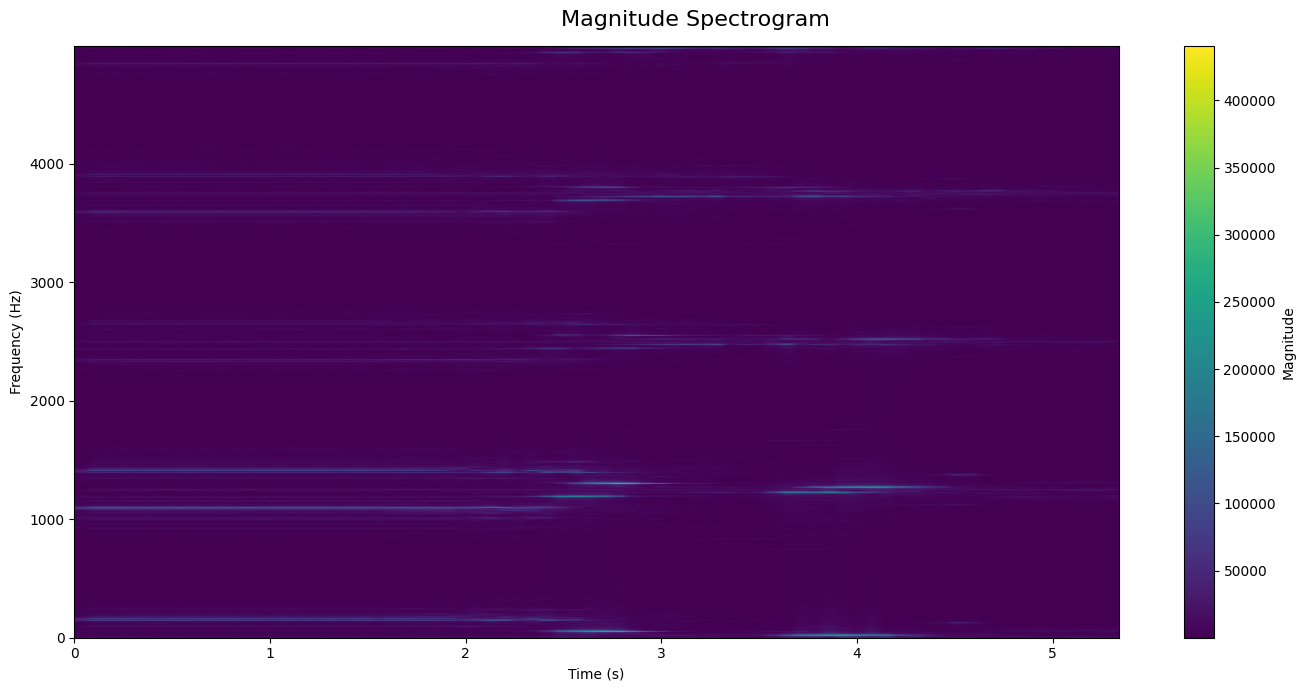

In [135]:
plt.figure(figsize=(14, 7))
plt.suptitle('Magnitude Spectrogram', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
extent = [0, tds[-1], 0, max(freqs)]
plt.imshow(np.abs(ffts[:len(freqs)//2, :]), aspect='auto', extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.tight_layout()

In [ ]:
def correlate_locs_and_meas(self, radar_type, robot_data, radar_data, exp_data, robot_loc_data=None, speed="speed_8"):
        """
        Find the robot locations where each radar measurement was taken by interpolating the robot trajectory.
        Only used in real world experiments.
        Parameters:
            radar_type (str): type of radar to use ("24_ghz, 77_ghz")
            robot_data (dict): loaded robot pickle file using the load_robot_file function
            radar_data (dict): loaded radar adc file using the load_radar_files function
            robot_loc_data (dict): loaded robot location data using the load_robot_loc_files function
            speed (str): the speed of the radar ("speed_4", "speed_8")

        Returns:
            Robot locations and radar data, with one-to-one correspondences
        """
        all_locs = []
        all_radar_data = []
        all_index = []
        assert radar_type in ['77_ghz', '24_ghz'], "Please choose a valid radar type."

        aperture_type = exp_data['aperture size']

        # Load imaging parameters
        params_dict = utilities.get_radar_parameters(radar_type=radar_type, is_sim=False, aperture_type=aperture_type)
        FREQUENCY = params_dict['min_f']
        NUM_FRAMES = params_dict['num_frames']
        SWEEP_TIME = params_dict['sweep_time']
        PERIODICITY = params_dict['periodicity']
        SAMPLES_PER_CHIRP = params_dict['num_samples']
        NUM_CHIRP = params_dict['num_chirps']
        wavelength = c / FREQUENCY
        repeated_meas_threshold = wavelength * (3 / 16)

        # Create interpolation functions for robot locations
        radar_type_num = radar_type[:2]
        robot_loc_data[f'times_{radar_type_num}'] = robot_loc_data[f'times_{radar_type_num}']
        interp_functs = self.get_interpolated_funct(robot_loc_data[f'times_{radar_type_num}'], robot_loc_data[f'tx_{radar_type_num}_locs'])

        # Find robot location for every radar measurement
        for i, filename in enumerate(robot_data['all_radar_filenames']):
            # Load radar file for this row
            created_ts = robot_data['all_radar_created_ts'][i]
            if created_ts == -1: continue
            if int(filename) not in radar_data:
                print(f"Couldn't find file {int(filename)}")
                continue

            # Each radar file contains NUM_FRAMES different radar measurements
            data = radar_data[int(filename)]
            current_row_locs = []
            for j in range(NUM_FRAMES):
                # Compute timestamp of jth measurement inside a file
                start = created_ts + j * (SWEEP_TIME + PERIODICITY)

                # Try to interpolate robot location at this measurement
                try:
                    loc = self.get_interpolated_transforms_from_funct(interp_functs, [start])[0]
                    # Remove two measurements that are too close together
                    if j != 0 and np.min(np.linalg.norm(np.array(current_row_locs)[:, :3] - loc[:3], axis=1)) < repeated_meas_threshold: 
                        continue
                except:
                    continue

                # Load radar data for this measurement
                new_data = data[j * SAMPLES_PER_CHIRP * NUM_CHIRP :
                                j * SAMPLES_PER_CHIRP * NUM_CHIRP + SAMPLES_PER_CHIRP, :]
                if ((radar_type == "24_ghz" and new_data.shape != (SAMPLES_PER_CHIRP, 2)) or
                    (radar_type == "77_ghz" and new_data.shape != (SAMPLES_PER_CHIRP, 4))):
                    print(f'File {filename} did not have expected number of frames. Skipping')
                    continue
                
                # Save data / location / index
                if self.is_optitrack: loc = self.convert_opt_frame(loc)
                all_locs.append(loc)
                current_row_locs.append(loc)
                all_radar_data.append(new_data)
                all_index.append(i * NUM_FRAMES + j)

        # Return all data
        all_locs = np.array(all_locs)
        data = {'radar_data': all_radar_data, 'poses': all_locs}
        return data


In [463]:
def load_radar_file(filepath, numRx, ):
    """
    Load raw radar files for processing (Note: this function is only needed when processing raw radar data into an image)

    Returns: 
        Loaded complex-valued radar (adc) files for the specified radar type
    """
    fid = open(f'{filepath}', 'rb')

    adcData = np.fromfile(fid, dtype='<i2')
    adcData = np.reshape(adcData, (int(adcData.shape[0] / (numRx * 2)), numRx * 2))
    adcData = adcData[:, [0, 1, 2, 3]] + 1j * adcData[:, [4, 5, 6, 7]]

    return adcData

In [466]:
c = 3e8  # Speed of light in m/s

# frame config
NUM_FRAMES = 1
NUM_CHIRP = 128                 # chirp loop count
PERIODICITY = 40                # periodicity in ms
# NUM_FRAMES = 100
# NUM_CHIRP = 32              # chirp loop count
# PERIODICITY = 100           # periodicity in ms

# profile config
FREQUENCY = 77                  # start frequency
SAMPLES_PER_CHIRP = 256         # ADC number of samples
SAMPLE_RATE_KHZ = 10000         # digout sample rate in kHz
RAMP_END_TIME_US = 60           # us
ADC_START_TIME_US = 6           # us
FREQ_SLOPE_MHZ = 29.982         # frequency slope in MHz (/us)

# chan & adc config
NUMRX = 4

SAMPLE_RATE = SAMPLE_RATE_KHZ * 1e3  # digout sample rate in Hz
# SWEEP_TIME = (RAMP_END_TIME_US - ADC_START_TIME_US) * 1e-6  # sweep time in seconds
SWEEP_TIME = SAMPLES_PER_CHIRP / SAMPLE_RATE
FREQ_SLOPE = FREQ_SLOPE_MHZ * 1e12  # frequency slope in Hz (/s)

BANDWIDTH = FREQ_SLOPE * SWEEP_TIME  # bandwidth in Hz
RESOLUTION = c / (2 * BANDWIDTH)  # range resolution in m

print(f"Start frequency: {FREQUENCY} Hz")
print(f"Bandwidth: {BANDWIDTH} Hz")
print(f"Sweep time: {SWEEP_TIME} s")
print(f"Slope: {FREQ_SLOPE} Hz/s")
print(f"Range resolution: {RESOLUTION} m")
print(f"Sample rate: {SAMPLE_RATE} Hz")

adcData = load_radar_file('./adc_data_1m.bin', 4)
print("ADC Data shape:", adcData.shape)
# adcData 

Start frequency: 77 Hz
Bandwidth: 767539200.0 Hz
Sweep time: 2.56e-05 s
Slope: 29982000000000.0 Hz/s
Range resolution: 0.19542975785471284 m
Sample rate: 10000000.0 Hz
ADC Data shape: (32768, 4)


In [467]:
# reshape adcData to (num samples per chirp, num chirps, num frames, num rx)
chirps = adcData.reshape(NUM_FRAMES, NUM_CHIRP, SAMPLES_PER_CHIRP, NUMRX)
print("Chirps shape:", chirps.shape)

Chirps shape: (1, 128, 256, 4)


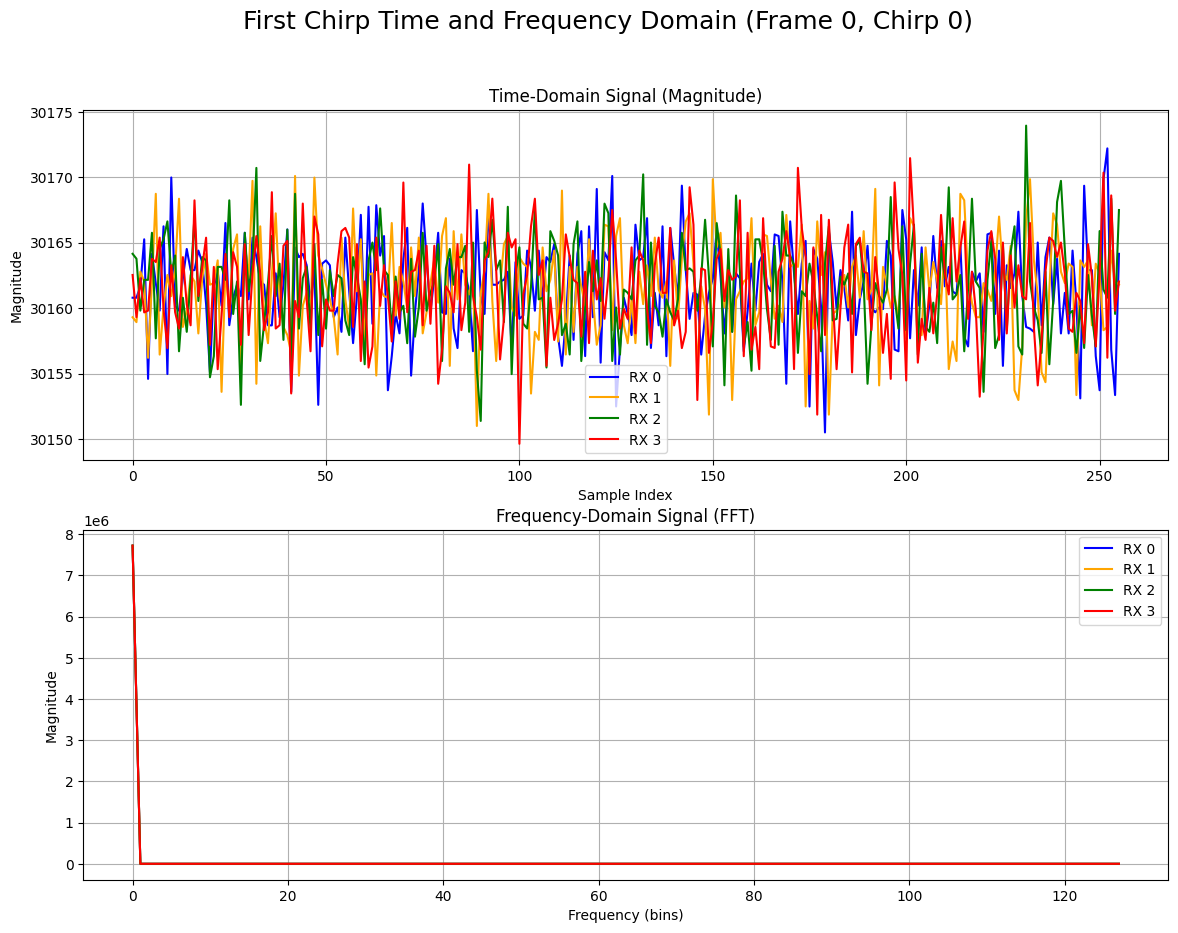

In [476]:
frame_idx = 0
chirp_idx = 0

# FFT on the first chirps across all RXs
first_chirp_ffts = np.array([fft(chirps[frame_idx, chirp_idx, :, rx]) for rx in range(NUMRX)])
N = first_chirp_ffts.shape[1]

fig, axs = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('First Chirp Time and Frequency Domain (Frame 0, Chirp 0)', fontsize=18)

# Subplot 1: Time-domain magnitude
axs[0].plot(np.abs(chirps[chirp_idx, frame_idx, :, 0]), label='RX 0', color='blue')
axs[0].plot(np.abs(chirps[chirp_idx, frame_idx, :, 1]), label='RX 1', color='orange')
axs[0].plot(np.abs(chirps[chirp_idx, frame_idx, :, 2]), label='RX 2', color='green')
axs[0].plot(np.abs(chirps[chirp_idx, frame_idx, :, 3]), label='RX 3', color='red')
axs[0].set_title('Time-Domain Signal (Magnitude)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Frequency-domain magnitude (FFT of RX 0)
axs[1].plot(np.abs(first_chirp_ffts[0, :N//2]), label='RX 0', color='blue')
axs[1].plot(np.abs(first_chirp_ffts[1, :N//2]), label='RX 1', color='orange')
axs[1].plot(np.abs(first_chirp_ffts[2, :N//2]), label='RX 2', color='green')
axs[1].plot(np.abs(first_chirp_ffts[3, :N//2]), label='RX 3', color='red')
axs[1].set_title('Frequency-Domain Signal (FFT)')
axs[1].set_xlabel('Frequency (bins)')
axs[1].set_ylabel('Magnitude')
axs[1].legend()
axs[1].grid(True)

In [477]:
# coherently average the chirps for each frame
chirps_avg = np.mean(chirps, axis=1)                    # Average across chirps
print("Chirps Average shape:", chirps_avg.shape)

Chirps Average shape: (1, 256, 4)


In [478]:
# remove DC from all data
chirps_no_dc = chirps_avg - np.mean(chirps_avg, axis=1, keepdims=True)
print("Chirps No DC shape:", chirps_no_dc.shape)

Chirps No DC shape: (1, 256, 4)


In [ ]:
# frame-to-frame background subtraction


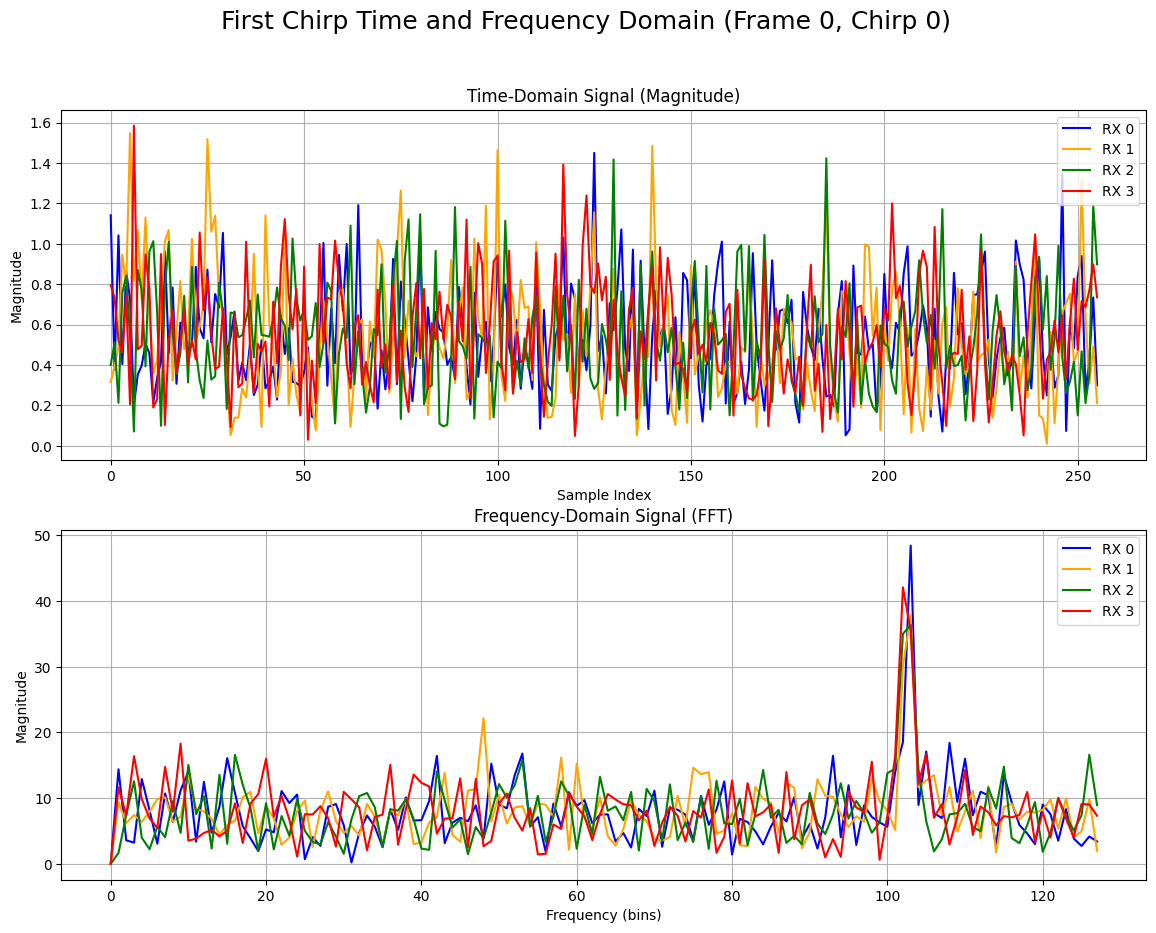

In [479]:
frame_idx = 0

# FFT on the first chirps across all RXs
first_chirp_ffts = np.array([fft(chirps_no_dc[frame_idx, :, rx]) for rx in range(NUMRX)])
N = first_chirp_ffts.shape[1]

fig, axs = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('First Chirp Time and Frequency Domain (Frame 0, Chirp 0)', fontsize=18)

# Subplot 1: Time-domain magnitude
axs[0].plot(np.abs(chirps_no_dc[frame_idx, :, 0]), label='RX 0', color='blue')
axs[0].plot(np.abs(chirps_no_dc[frame_idx, :, 1]), label='RX 1', color='orange')
axs[0].plot(np.abs(chirps_no_dc[frame_idx, :, 2]), label='RX 2', color='green')
axs[0].plot(np.abs(chirps_no_dc[frame_idx, :, 3]), label='RX 3', color='red')
axs[0].set_title('Time-Domain Signal (Magnitude)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Frequency-domain magnitude (FFT of RX 0)
axs[1].plot(np.abs(first_chirp_ffts[0, :N//2]), label='RX 0', color='blue')
axs[1].plot(np.abs(first_chirp_ffts[1, :N//2]), label='RX 1', color='orange')
axs[1].plot(np.abs(first_chirp_ffts[2, :N//2]), label='RX 2', color='green')
axs[1].plot(np.abs(first_chirp_ffts[3, :N//2]), label='RX 3', color='red')
axs[1].set_title('Frequency-Domain Signal (FFT)')
axs[1].set_xlabel('Frequency (bins)')
axs[1].set_ylabel('Magnitude')
axs[1].legend()
axs[1].grid(True)

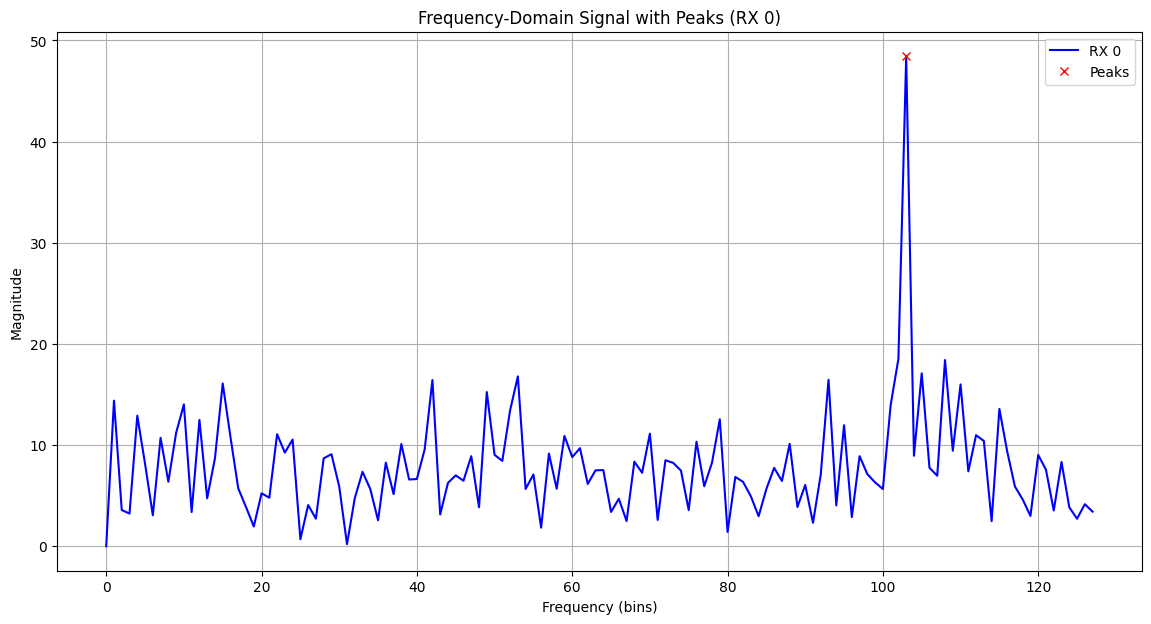

In [481]:
# scipy find peak on np.abs(first_chirp_ffts[0, :])

from scipy.signal import find_peaks

peaks, _ = find_peaks(np.abs(first_chirp_ffts[0, :N//2]), height=20)

# plot
plt.figure(figsize=(14, 7))
plt.plot(np.abs(first_chirp_ffts[0, :N//2]), label='RX 0', color='blue')
plt.plot(peaks, np.abs(first_chirp_ffts[0, peaks]), "x", label='Peaks', color='red')
plt.title('Frequency-Domain Signal with Peaks (RX 0)')
plt.xlabel('Frequency (bins)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

In [482]:
# print peaks found:
for peak in peaks:
    print(f"Peak at index {peak}, range: {peak * RESOLUTION:.2f} m, frequency: {peak * SAMPLE_RATE / SAMPLES_PER_CHIRP / 1e6:.2f} MHz")

Peak at index 103, range: 20.13 m, frequency: 4.02 MHz


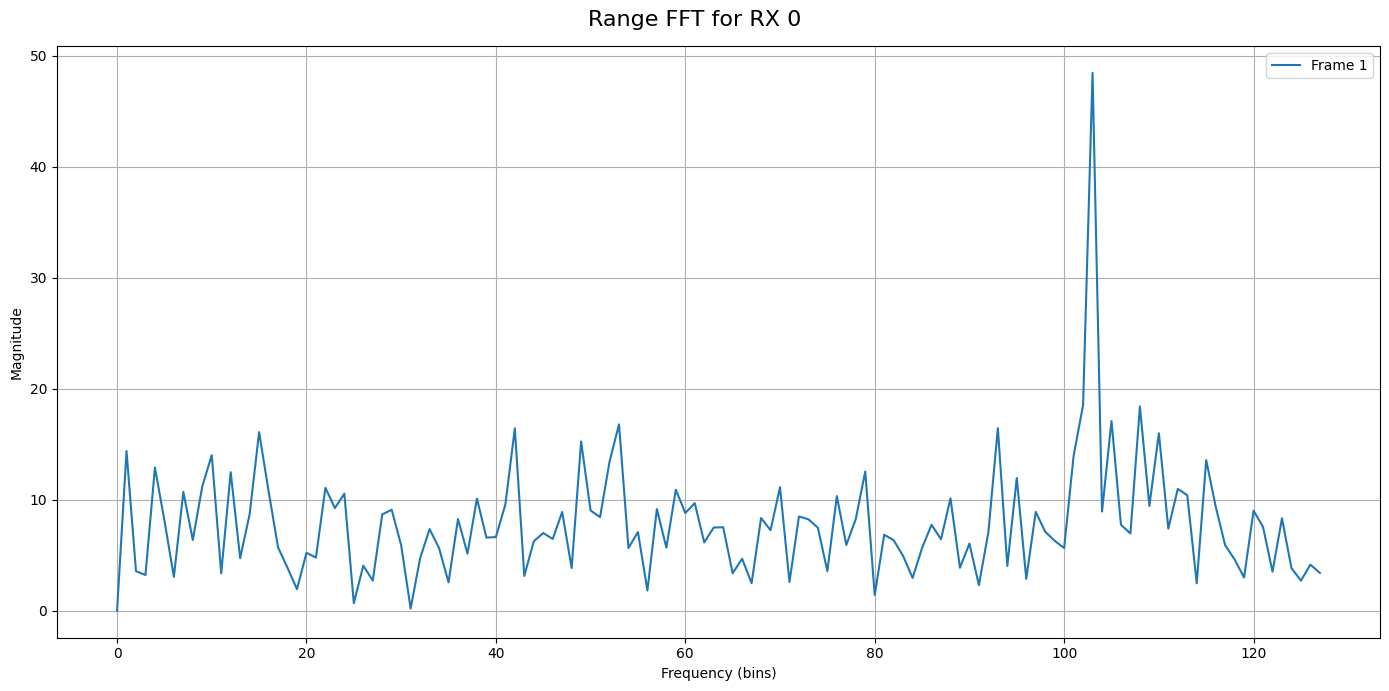

In [485]:
rx_idx = 0

# get range FFT of chirp for every frame
chirps_data = chirps_no_dc[:, :, rx_idx]                    # shape (frames, samples)

# Apply FFT along the sample (fast time) axis
range_ffts = fft(chirps_data, axis=1)                       # shape (frames, samples)
N = range_ffts.shape[1]                                      # number of samples

# Plot the range FFT for the first 3 frames
plt.figure(figsize=(14, 7))
plt.suptitle('Range FFT for RX 0', fontsize=16)
plt.xlabel('Frequency (bins)')
plt.ylabel('Magnitude')
for frame in range(NUM_FRAMES):
    plt.plot(np.abs(range_ffts[frame, :N//2]), label=f'Frame {frame + 1}')
plt.legend()
plt.grid(True)
plt.tight_layout()

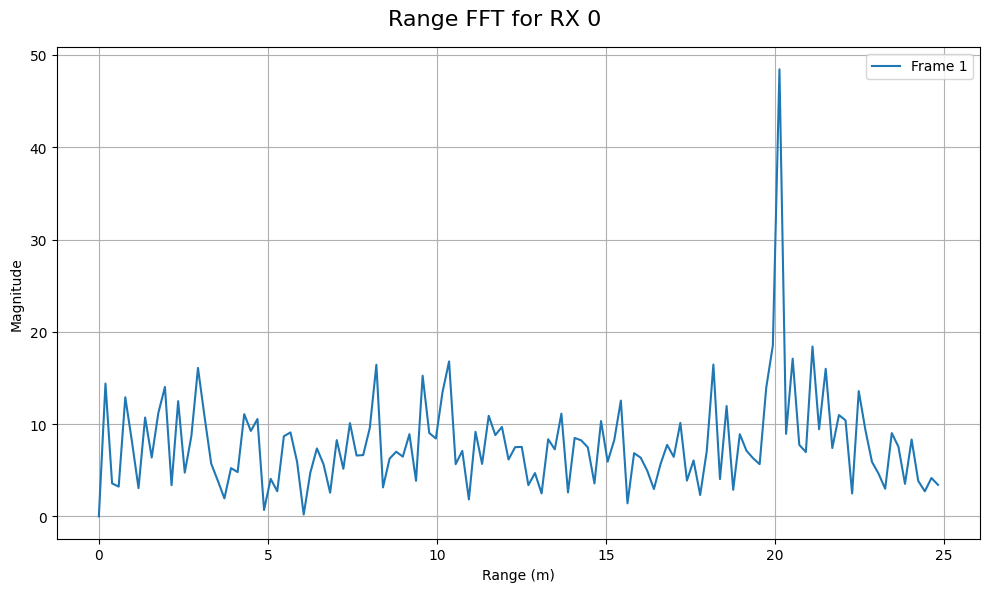

In [488]:
# convert freqs to meters
# resolution = c / (2 * BANDWIDTH)                            # resolution in meters
# range_meters = np.arange(SAMPLES_PER_CHIRP) * resolution    # range in meters
N = range_ffts.shape[1]  # number of samples
fft_freqs = fftfreq(N, 1 / (SAMPLE_RATE))  # Frequency bins
range_meters = fft_freqs[:N//2] * c / (2 * FREQ_SLOPE)

# Plot the range FFT for all frames
plt.figure(figsize=(10, 6))
plt.suptitle('Range FFT for RX 0', fontsize=16)
for frame in range(NUM_FRAMES):
    plt.plot(range_meters, np.abs(range_ffts[frame, :N//2]), label=f'Frame {frame + 1}')
plt.xlabel('Range (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [449]:
BANDWIDTH / 1e9

0.7675392

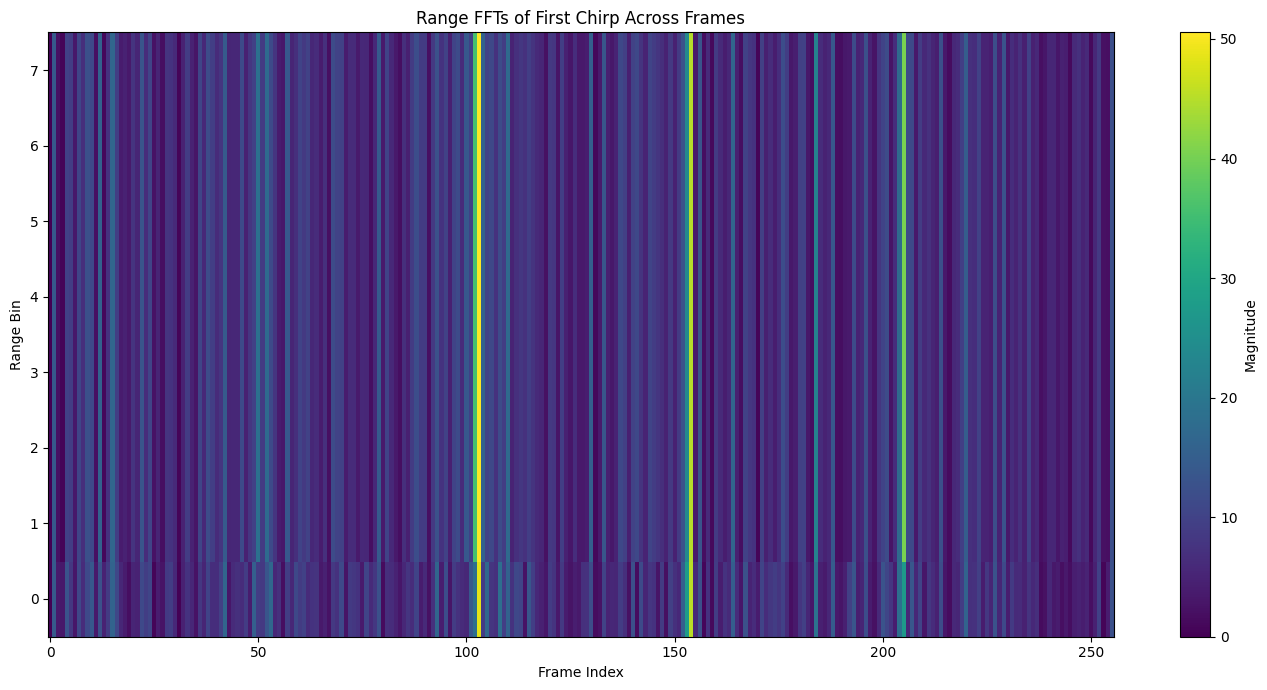

In [450]:
# range FFTs for all frames
plt.figure(figsize=(14, 7))
plt.imshow(np.abs(range_ffts), aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Magnitude')
plt.title("Range FFTs of First Chirp Across Frames")
plt.xlabel("Frame Index")
plt.ylabel("Range Bin")
plt.tight_layout()

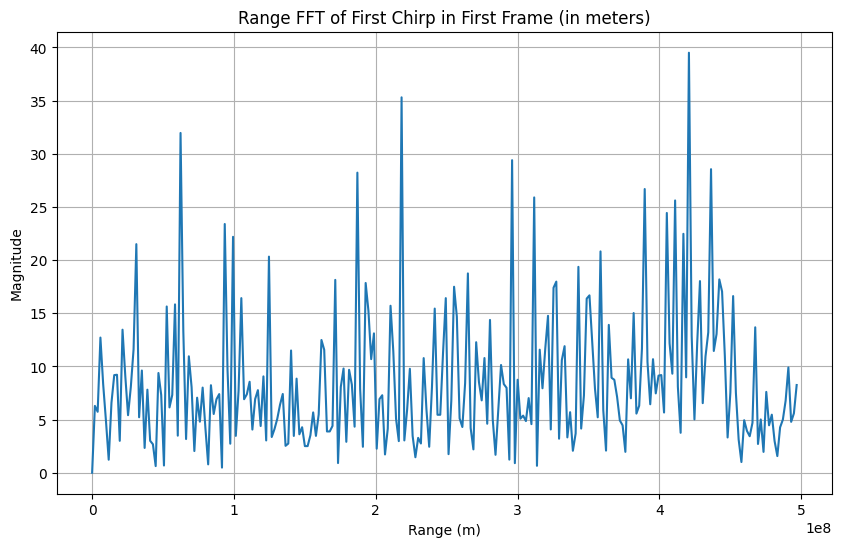

In [253]:
# covert range bins to meters
range_bins = np.arange(SAMPLES_PER_CHIRP)
range_meters = range_bins * (c / (2 * FREQUENCY))  # c / (2 * frequency) gives the range resolution in meters

# Plot the range in meters
plt.figure(figsize=(10, 6))
plt.plot(range_meters, np.abs(range_ffts[:, 0]), label='Range FFT of First Chirp in First Frame')
plt.title("Range FFT of First Chirp in First Frame (in meters)")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude")
plt.grid(True)